In [86]:
import os
import numpy as np
import logging
import time
from collections import Counter

import hdbscan
from pathlib import Path
from hdbscan import validity
from sklearn.manifold import TSNE
from tqdm import tqdm
from joblib import Parallel, delayed

import multiprocessing as mp
import matplotlib.pyplot as plt
from shutil import copyfile

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
now_times = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())


In [87]:
protein_pdb = "/mnt/nas1/lanwei-125/FGF5/dock_prepare/FGF5.pdb"
peptide_pdb_dir = "/mnt/nas1/lanwei-125/FGF5/disulfide_peptide/"
cluster_path = "/mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster/"

protein_pdb = Path(protein_pdb)
peptide_pdb_dir = Path(peptide_pdb_dir)
cluster_path = Path(cluster_path)


DBCV_score_vs_trials = cluster_path / "DBCV_score_vs_trials.png"
cluster_result = cluster_path / "cluster_result.txt"
point_plot = cluster_path / "cluster_point_plot.png"

HPEP = False  # if your structures are from HPEP, set it to True, else set it to False
ADCP = False  # if your structures are from ADCP, set it to True, else set it to False
contact_cutoff = 7  # 6 angstroms

In [88]:
protein_coords = []
with open(protein_pdb) as f:
    for line in f:
        if line.startswith("ATOM"):
            x = float(line[30:38])
            y = float(line[38:46])
            z = float(line[46:54])
            protein_coords.append([x, y, z])
logger.info(f"Read protein {len(protein_coords)} atom coordinates from target PDB file.")


2023-12-15 11:24:08,223 - INFO - Read protein 2091 atom coordinates from PDB file.
2023-12-15 11:24:08,223 - INFO - Read protein 2091 atom coordinates from PDB file.
2023-12-15 11:24:08,223 - INFO - Read protein 2091 atom coordinates from PDB file.
2023-12-15 11:24:08,223 - INFO - Read protein 2091 atom coordinates from PDB file.
2023-12-15 11:24:08,223 - INFO - Read protein 2091 atom coordinates from PDB file.


In [89]:
peptide_coords = []
peptide_names = []
for pdb_path in Path(peptide_pdb_dir).glob("*.pdb"):
    coords = []
    with open(pdb_path) as f:
        for line in f:
            if line.startswith("ATOM"):
                x = float(line[30:38])
                y = float(line[38:46])
                z = float(line[46:54])
                coords.append([x, y, z])
    peptide_coords.append(coords)
    peptide_names.append(pdb_path.stem)
    
logger.info(f'{now_times}: read {len(peptide_coords)} peptides')


2023-12-15 11:24:10,099 - INFO - 2023-12-15 11:24:05: read 234 peptides
2023-12-15 11:24:10,099 - INFO - 2023-12-15 11:24:05: read 234 peptides
2023-12-15 11:24:10,099 - INFO - 2023-12-15 11:24:05: read 234 peptides
2023-12-15 11:24:10,099 - INFO - 2023-12-15 11:24:05: read 234 peptides
2023-12-15 11:24:10,099 - INFO - 2023-12-15 11:24:05: read 234 peptides


In [90]:
def calc_contacts(peptide_idx, peptide_coords, protein_coords, contact_cutoff):
    """
    Calculate the number of contacts between a peptide and a protein.

    Parameters:
    - peptide_idx (int): The index of the peptide in the list of peptide coordinates.
    - peptide_coords (list): A list of lists containing the coordinates of each peptide.
    - protein_coords (list): A list containing the coordinates of the protein.
    - contact_cutoff (float): The distance threshold for considering a contact.

    Returns:
    - dists (list): A list containing the number of contacts for each protein coordinate.
    """
    dists = [0] * len(protein_coords)
    for p_idx, p_coord in enumerate(protein_coords):
        contact = 0
        for pe_coord in peptide_coords[peptide_idx]:
            dist = np.linalg.norm(np.array(p_coord) - np.array(pe_coord))
            if dist < contact_cutoff:
                contact += 1
        dists[p_idx] = contact
 
    return dists

In [91]:
contact_matrices = []
with mp.Pool() as pool:
    results = [
        pool.apply_async(
            calc_contacts, args=(i, peptide_coords, protein_coords, contact_cutoff)
        )
        for i in range(len(peptide_coords))
    ]
    contact_matrices = [r.get() for r in results]
logger.info(f'{now_times} contact_matrices length: {len(contact_matrices)}')

2023-12-15 11:24:51,414 - INFO - 2023-12-15 11:24:05 contact_matrices length: 234
2023-12-15 11:24:51,414 - INFO - 2023-12-15 11:24:05 contact_matrices length: 234
2023-12-15 11:24:51,414 - INFO - 2023-12-15 11:24:05 contact_matrices length: 234
2023-12-15 11:24:51,414 - INFO - 2023-12-15 11:24:05 contact_matrices length: 234
2023-12-15 11:24:51,414 - INFO - 2023-12-15 11:24:05 contact_matrices length: 234


In [92]:
contact_matrixs = []
for dists in contact_matrices:
    contact_matrixs.append(dists)
contact_matrixs = np.array(contact_matrixs)

logger.info(f"contact_matrices length: {len(contact_matrices)}")

2023-12-15 11:29:22,136 - INFO - contact_matrices length: 234
2023-12-15 11:29:22,136 - INFO - contact_matrices length: 234
2023-12-15 11:29:22,136 - INFO - contact_matrices length: 234
2023-12-15 11:29:22,136 - INFO - contact_matrices length: 234
2023-12-15 11:29:22,136 - INFO - contact_matrices length: 234


100%|██████████| 90/90 [00:08<00:00, 10.67it/s]


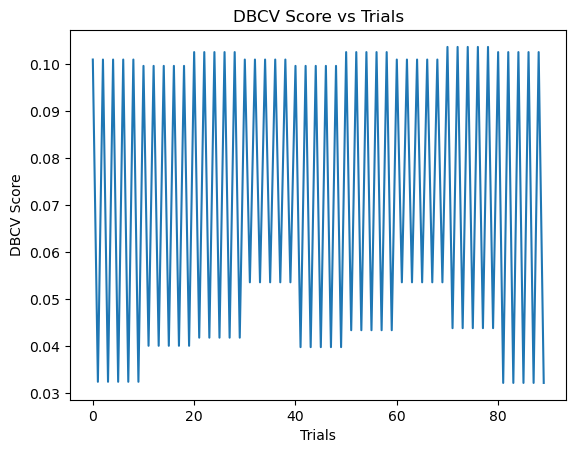

2023-12-15 11:29:41,056 - INFO - 2023-12-15 11:24:05 Best Model: HDBSCAN(cluster_selection_epsilon=0.1, core_dist_n_jobs=-1,
        gen_min_span_tree=True, min_cluster_size=4, min_samples=3), Score: 0.1036199056485574
2023-12-15 11:29:41,056 - INFO - 2023-12-15 11:24:05 Best Model: HDBSCAN(cluster_selection_epsilon=0.1, core_dist_n_jobs=-1,
        gen_min_span_tree=True, min_cluster_size=4, min_samples=3), Score: 0.1036199056485574
2023-12-15 11:29:41,056 - INFO - 2023-12-15 11:24:05 Best Model: HDBSCAN(cluster_selection_epsilon=0.1, core_dist_n_jobs=-1,
        gen_min_span_tree=True, min_cluster_size=4, min_samples=3), Score: 0.1036199056485574
2023-12-15 11:29:41,056 - INFO - 2023-12-15 11:24:05 Best Model: HDBSCAN(cluster_selection_epsilon=0.1, core_dist_n_jobs=-1,
        gen_min_span_tree=True, min_cluster_size=4, min_samples=3), Score: 0.1036199056485574
2023-12-15 11:29:41,056 - INFO - 2023-12-15 11:24:05 Best Model: HDBSCAN(cluster_selection_epsilon=0.1, core_dist_n_jobs=-1,

In [93]:

scores = {}

def run_hdbscan(params):
    min_cluster_size, min_samples, eps, cluster_selection_method = params
    hdb = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=eps,
        cluster_selection_method=cluster_selection_method,
        gen_min_span_tree=True,
        core_dist_n_jobs=-1,
    ).fit(contact_matrixs)
    score = hdb.relative_validity_
    return hdb, score

min_cluster_sizes = list(range(2, 5))
min_samples_values = list(range(2, 5))
eps_values = [x * 0.1 for x in range(1, 10, 2)]
cluster_selection_methods = ["eom", "leaf"]

param_combinations = [
    (min_cluster_size, min_samples, eps, cluster_selection_method)
    for min_cluster_size in min_cluster_sizes
    for min_samples in min_samples_values
    for eps in eps_values
    for cluster_selection_method in cluster_selection_methods
]

results = Parallel(n_jobs=-1)(
    delayed(run_hdbscan)(params) for params in tqdm(param_combinations)
)


for hdb, score in results:
    scores[hdb] = score

plt.plot(list(range(len(scores))), scores.values())
plt.xlabel("Trials")
plt.ylabel("DBCV Score")
plt.title("DBCV Score vs Trials")
plt.show()
#plt.savefig(DBCV_score_vs_trials)

best_model = max(scores, key=scores.get)

logger.info(f"{now_times} Best Model: {best_model}, Score: {scores[best_model]}")

In [113]:
hdb = hdbscan.HDBSCAN(cluster_selection_epsilon=0.1, core_dist_n_jobs=-1,
        gen_min_span_tree=True, min_cluster_size=2, min_samples=2).fit(contact_matrixs)
labels = hdb.labels_
score = hdb.relative_validity_
logger.info(f'{now_times} Best Model: {best_model}, Score: {score}')

2023-12-15 13:49:07,316 - INFO - 2023-12-15 11:24:05 Best Model: HDBSCAN(cluster_selection_epsilon=0.1, core_dist_n_jobs=-1,
        gen_min_span_tree=True, min_cluster_size=4, min_samples=3), Score: 0.10093679274589354
2023-12-15 13:49:07,316 - INFO - 2023-12-15 11:24:05 Best Model: HDBSCAN(cluster_selection_epsilon=0.1, core_dist_n_jobs=-1,
        gen_min_span_tree=True, min_cluster_size=4, min_samples=3), Score: 0.10093679274589354
2023-12-15 13:49:07,316 - INFO - 2023-12-15 11:24:05 Best Model: HDBSCAN(cluster_selection_epsilon=0.1, core_dist_n_jobs=-1,
        gen_min_span_tree=True, min_cluster_size=4, min_samples=3), Score: 0.10093679274589354
2023-12-15 13:49:07,316 - INFO - 2023-12-15 11:24:05 Best Model: HDBSCAN(cluster_selection_epsilon=0.1, core_dist_n_jobs=-1,
        gen_min_span_tree=True, min_cluster_size=4, min_samples=3), Score: 0.10093679274589354
2023-12-15 13:49:07,316 - INFO - 2023-12-15 11:24:05 Best Model: HDBSCAN(cluster_selection_epsilon=0.1, core_dist_n_jobs

In [114]:
cluster_keys = {}
for label in set(labels):
    tabel = int(label)
    cluster_keys[label] = []
for i, label in enumerate(labels):
    cluster_keys[label].append(peptide_names[i])
for label in sorted(cluster_keys):
    with open(cluster_result, "a+") as f:
        f.write(
            f"Cluster {label}:{cluster_keys[label]}\n {len(cluster_keys[label])}\n"
        )
logger.info(f"{now_times} Cluster information saved to {cluster_result}")

2023-12-15 13:49:09,387 - INFO - 2023-12-15 11:24:05 Cluster information saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster/cluster_result.txt
2023-12-15 13:49:09,387 - INFO - 2023-12-15 11:24:05 Cluster information saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster/cluster_result.txt
2023-12-15 13:49:09,387 - INFO - 2023-12-15 11:24:05 Cluster information saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster/cluster_result.txt
2023-12-15 13:49:09,387 - INFO - 2023-12-15 11:24:05 Cluster information saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster/cluster_result.txt
2023-12-15 13:49:09,387 - INFO - 2023-12-15 11:24:05 Cluster information saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster/cluster_result.txt


2023-12-15 11:29:59,757 - INFO - 2023-12-15 11:24:05 2D t-SNE plot saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster/cluster_point_plot.png
2023-12-15 11:29:59,757 - INFO - 2023-12-15 11:24:05 2D t-SNE plot saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster/cluster_point_plot.png
2023-12-15 11:29:59,757 - INFO - 2023-12-15 11:24:05 2D t-SNE plot saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster/cluster_point_plot.png
2023-12-15 11:29:59,757 - INFO - 2023-12-15 11:24:05 2D t-SNE plot saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster/cluster_point_plot.png
2023-12-15 11:29:59,757 - INFO - 2023-12-15 11:24:05 2D t-SNE plot saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster/cluster_point_plot.png


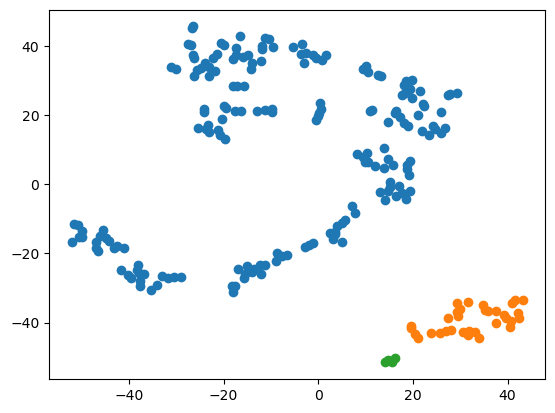

In [96]:
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(contact_matrixs)
fig, ax = plt.subplots()
for i in range(len(cluster_keys)):
    ax.scatter(
        X_tsne[labels == i, 0],
        X_tsne[labels == i, 1],
    )
plt.savefig(point_plot)
logger.info(f"{now_times} 2D t-SNE plot saved to {point_plot}")

['CNNINTPCGG',
 'ESCIEWTECL',
 'ECLTWTDECI',
 'MYCEYAYACS',
 'DQCMLPGCE',
 'CTDKEC',
 'EKCLGAFCFRRD',
 'CNIDGCKPK',
 'CTEKSC',
 'ECMYCEYM',
 'CTNQDC']

In [140]:
import random
import math
random_peptides= 50
def extract_random_peptides(cluster_keys, random_peptides):
    real_cluster = {}
    for i in range(0,len(cluster_keys)-1):
        a= cluster_keys[i]
        real_cluster[i] = a 

    total_peptides = sum(len(peptides) for peptides in real_cluster.values())
    weights = {label: len(peptides) / total_peptides for label, peptides in real_cluster.items()}
    peptides_to_extract = {label: math.ceil(random_peptides * weight) for label, weight in weights.items()}

    selected_peptides = {}
    for label, peptides in real_cluster.items():
        selected_peptides[label] = random.sample(peptides, peptides_to_extract[label])
        
    real_random_peptides = sum(len(peptides) for peptides in selected_peptides.values())
    logger.info(f"{now_times} {real_random_peptides} peptides are randomly selected")
    return selected_peptides
selected_peptides = extract_random_peptides(cluster_keys, random_peptides)
selected_peptides






2023-12-15 14:29:15,573 - INFO - 2023-12-15 11:24:05 51 peptides are randomly selected
2023-12-15 14:29:15,573 - INFO - 2023-12-15 11:24:05 51 peptides are randomly selected
2023-12-15 14:29:15,573 - INFO - 2023-12-15 11:24:05 51 peptides are randomly selected
2023-12-15 14:29:15,573 - INFO - 2023-12-15 11:24:05 51 peptides are randomly selected
2023-12-15 14:29:15,573 - INFO - 2023-12-15 11:24:05 51 peptides are randomly selected


{0: ['CTNKPNEPC',
  'ECSIIWCSL',
  'CNNILCPT',
  'CPPQDPSC',
  'CSMEQC',
  'CWTSGPPC',
  'CEIEWCTM',
  'CTDKEPPC',
  'GKCHAAFCFRRD',
  'CIELPWMCI',
  'CTEKPSEC',
  'CKEMEC',
  'GSCFGVPCFRSD',
  'CSEKSC',
  'CYIQPCWTG',
  'CKPDHC',
  'CSPEKC',
  'CHPKTAGC',
  'CQNTEC',
  'CQSSEC',
  'EECIWCMTL',
  'CYIQACTVG',
  'CTPEKCPS',
  'CYSFECPLG',
  'QCNVPSCLT',
  'CNSIGC',
  'SCAINNCPM',
  'CNGTNC',
  'GSCTDAECFRRD',
  'CSFEFC',
  'CTNQEC',
  'GSCFGAMCKKRD',
  'CYIQPCPTG',
  'CSMMQPCLG',
  'CHPKHIEC',
  'CTPKEC',
  'CTQGEC',
  'CYIQHCEVG',
  'CPVDKPQC',
  'DCGAMICYEY',
  'CNGTSC',
  'CYIQLCVLG'],
 1: ['CTKEDDCPK',
  'CPDKDDPC',
  'CTEDEC',
  'SECEMCPDK',
  'CTEDKC',
  'CTPEDC',
  'CTQEEPDC',
  'ECAEEYCMY'],
 2: ['CTSESDC']}

In [108]:

cluster_dir_list = []
for labels, value  in selected_peptides.items():
    if isinstance(value, tuple):
        peptides,_ = value
    else:
        peptides = value

    labels = str(labels)
    for label in labels:
        for peptide in peptides:
        
            cluster_dir = Path(cluster_path) / f"cluster_{label}"
            cluster_dir_list.append(cluster_dir)

            if not cluster_dir.exists():
                cluster_dir.mkdir(parents=True, exist_ok=True)

            original_pdb = Path(peptide_pdb_dir) / f"{peptide}.pdb"
            clustered_pdb = cluster_dir / f"{peptide}.pdb"

            if not clustered_pdb.exists():
                copyfile(original_pdb, clustered_pdb)

In [144]:
cluster_label_pdbs = []
cluster_laber_tags = []
for cluster_labels_keys in cluster_keys.keys():
    cluster_laber_tags.append(int(cluster_labels_keys))
    cluster_label_pdbs.append(cluster_keys[cluster_labels_keys])
type(cluster_laber_tags)


list

In [145]:
for cluster_label_pdb, cluster_laber_tag in zip(cluster_label_pdbs, cluster_laber_tags):
    out_file = Path(cluster_path) / f"{cluster_laber_tag}.pdb"
    i = 0
    for pdb in cluster_label_pdb:
        pdb_file = Path(peptide_pdb_dir) / f"{pdb}.pdb"
        with open(out_file, "a") as f_out, open(pdb_file) as f_in:
            i = i + 1
            f_out.write(f"\nMODEL {i}\n")
            # Filter out MODEL/END/ENDMDL lines
            lines = [
                line
                for line in f_in
                if "MODEL" not in line
                and "END" not in line
                and "ENDMDL" not in line
            ]
            f_out.write("".join(lines))
            f_out.write(f_in.read())
            f_out.write("END\n")
            f_out.write("ENDMDL\n\n")    
logger.info(f"{now_times} Clustered PDB files saved to {cluster_path}")


2023-12-15 14:30:35,531 - INFO - 2023-12-15 11:24:05 Clustered PDB files saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster
2023-12-15 14:30:35,531 - INFO - 2023-12-15 11:24:05 Clustered PDB files saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster
2023-12-15 14:30:35,531 - INFO - 2023-12-15 11:24:05 Clustered PDB files saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster
2023-12-15 14:30:35,531 - INFO - 2023-12-15 11:24:05 Clustered PDB files saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster
2023-12-15 14:30:35,531 - INFO - 2023-12-15 11:24:05 Clustered PDB files saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster


In [124]:
cluster_labels_pdb = []
cluster_laber_tags = []
for cluster_labels_keys in cluster_keys.keys():
    cluster_laber_tags.append(cluster_labels_keys)
    cluster_labels_pdb.append(cluster_keys[cluster_labels_keys])

a = -2
for cluster_label_pdb in cluster_labels_pdb:
    i = 0
    a = a + 1
    # Define output pdb filename
    out_file = Path(cluster_path) / f"{a}.pdb"

    for pdb in cluster_label_pdb:
        pdb_file = Path(peptide_pdb_dir) / f"{pdb}.pdb"
        with open(out_file, "a") as f_out, open(pdb_file) as f_in:
            i = i + 1
            f_out.write(f"\nMODEL {i}\n")
            # Filter out MODEL/END/ENDMDL lines
            lines = [
                line
                for line in f_in
                if "MODEL" not in line
                and "END" not in line
                and "ENDMDL" not in line
            ]
            f_out.write("".join(lines))
            f_out.write(f_in.read())
            f_out.write("END\n")
            f_out.write("ENDMDL\n\n")
logger.info(f"{now_times} Clustered PDB files saved to {cluster_path}")

2023-12-15 14:16:37,981 - INFO - 2023-12-15 11:24:05 Clustered PDB files saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster
2023-12-15 14:16:37,981 - INFO - 2023-12-15 11:24:05 Clustered PDB files saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster
2023-12-15 14:16:37,981 - INFO - 2023-12-15 11:24:05 Clustered PDB files saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster
2023-12-15 14:16:37,981 - INFO - 2023-12-15 11:24:05 Clustered PDB files saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster
2023-12-15 14:16:37,981 - INFO - 2023-12-15 11:24:05 Clustered PDB files saved to /mnt/nas1/lanwei-125/FGF5/disulfide_peptide_cluster
